In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from MLP import MLP
import os
from compare_data import compare_with_data
from utils import get_mean_norm, log_to_lin, lin_to_log
from iterators import data_iterators


/home/rodrigo/Desktop/McGill/Research/Rates/rate_modelling/compare_data.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = subset[df['K'] == k_closest]



    Using M = 0
        P = 1000.0 
        K = 300.0 
        T = 0.261
    Error: 15.74%
    


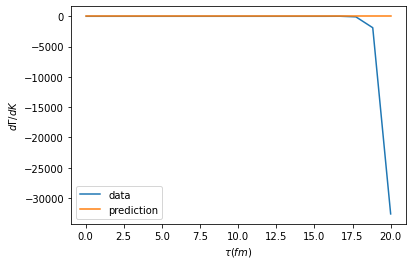

In [2]:
batch_size = 64
h_dim = 64
n_layers = 6
method=0

datafile = f'method_{method}.csv'

(_, _, test), consts_dict = data_iterators(
    batch_size=batch_size,
    datafile=datafile
    )

model_file = f'M_{method}_n_layers_{n_layers}_hid_dim_{h_dim}_val_pc_err=3.66e-02.ckpt'
model_path = os.path.join("Results", "saved_models", f"Method_{method}", model_file)

model = MLP.load_from_checkpoint(
    checkpoint_path=model_path,
    hidden_dim=h_dim,
    n_layers=n_layers,
    consts_dict=consts_dict
    )

P = 1600
K = 300
T = 0.3

compare_with_data(P, K, T, datafile, model, h_dim, n_layers)

In [27]:
Ks = np.linspace(0.1, 0.9, 9, endpoint=True)
Ts =  np.linspace(0.05, 1, 10).round(3)
ts = np.logspace(np.log10(0.05), np.log10(20), 100).round(3)

p_mean, p_norm = get_mean_norm(Ps)
T_mean, T_norm = get_mean_norm(Ts, log=False)
t_mean, t_norm = get_mean_norm(ts)

# print(p_mean, p_norm)
splits = 3
Ps = np.logspace(np.log10(5), 3, 10).round(3)
lin_spaced = np.log10(Ps)
print(lin_spaced)
for i in range(splits):
    l2 = (lin_spaced[1:] + lin_spaced[:-1])/2
    lin_spaced = np.concatenate((lin_spaced, l2))
    lin_spaced = np.unique(lin_spaced)
    lin_spaced = np.sort(lin_spaced)
print(lin_spaced)

# Ps = np.logspace(np.log10(5), 3, 20).round(3)
# print(Ps)
# print(log_to_lin(Ps, p_mean, p_norm))
# print(lin_to_log(log_to_lin(Ps, p_mean, p_norm), p_mean, p_norm))

[0.69897    0.95462838 1.21031852 1.46597737 1.72165401 1.97732113
 2.23299103 2.48866069 2.74432976 3.        ]
[0.69897    0.7309273  0.7628846  0.79484189 0.82679919 0.85875649
 0.89071378 0.92267108 0.95462838 0.98658965 1.01855091 1.05051218
 1.08247345 1.11443472 1.14639598 1.17835725 1.21031852 1.24227588
 1.27423323 1.30619059 1.33814794 1.3701053  1.40206266 1.43402001
 1.46597737 1.49793695 1.52989653 1.56185611 1.59381569 1.62577527
 1.65773485 1.68969443 1.72165401 1.7536124  1.78557079 1.81752918
 1.84948757 1.88144596 1.91340435 1.94536274 1.97732113 2.00927986
 2.0412386  2.07319734 2.10515608 2.13711482 2.16907355 2.20103229
 2.23299103 2.26494974 2.29690844 2.32886715 2.36082586 2.39278457
 2.42474327 2.45670198 2.48866069 2.52061932 2.55257795 2.58453659
 2.61649522 2.64845386 2.68041249 2.71237113 2.74432976 2.77628854
 2.80824732 2.8402061  2.87216488 2.90412366 2.93608244 2.96804122
 3.        ]
